In [1]:
import time
import os
import torch
import torch.nn as nn
import numpy as np
from numpy import vectorize

from torch.optim import LBFGS, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.parameter import Parameter
from tqdm import tqdm


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec

torch.set_default_dtype(torch.float64)
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype  = torch.float64

In [2]:
class ConventBlock(torch.nn.Module):
    def __init__(self,in_N,out_N):
        super(ConventBlock, self).__init__()
        self.Ls  = None
        self.net =torch.nn.Sequential(torch.nn.Linear(in_N,out_N),torch.nn.Tanh())  
        #self.net =torch.nn.Sequential(torch.nn.Linear(in_N,out_N),torch.nn.Sigmoid())
    def forward(self, x):
        out = self.net(x)
        return out 

In [3]:
class Network(torch.nn.Module):
    def __init__(self,layers,**kwargs):
        super(Network,self).__init__()
        self.mu    = kwargs["mean"]
        self.stdev = kwargs["stdev"]
            
        _layers = [] 
        for i in range(0,len(layers)-2):
            _layers.append(ConventBlock(layers[i],layers[i+1]))
            
        _layers.append(torch.nn.Linear(layers[-2],layers[-1]))
        self.net = torch.nn.Sequential(*_layers)
        
    def forward(self,x,t):
        data = torch.cat((x,t),dim=1);
        # normalize the input
        data = (data - self.mu)/self.stdev
        out    = self.net(data)
        T        =  out[:,0].reshape(-1,1)
        sigma    =  out[:,1].reshape(-1,1)
        return T,sigma
        
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.zeros_(m.bias)

In [4]:
global k 
pi = np.pi

    
def u_exact(x,t):
    """ Exact solution """
    if x < 0 :
        return    np.sin(3 * pi * x) * t 
    else :
        return    t * x
    
def ux_exact(x,t):
    """ Exact heat flux """
    if x < 0. :
        return    3 * pi * np.cos(3 * pi * x) * t 
    else :
        return    t  
    

def k_exact(x,t):
    """ Exact heat flux """
    if x < 0. :
        return    1.0
    else :
        return    3.0 * pi
    
    
def sigma_exact(x,t):
    """ Exact heat flux """
    return  k_exact(x,t) * ux_exact(x,t)

    
def source_exact(x,t):
    """heat source"""
    if x < 0. :
        return    9*pi**2*t*np.sin(3*pi*x) + np.sin(3*pi*x)
    else :
        return    x

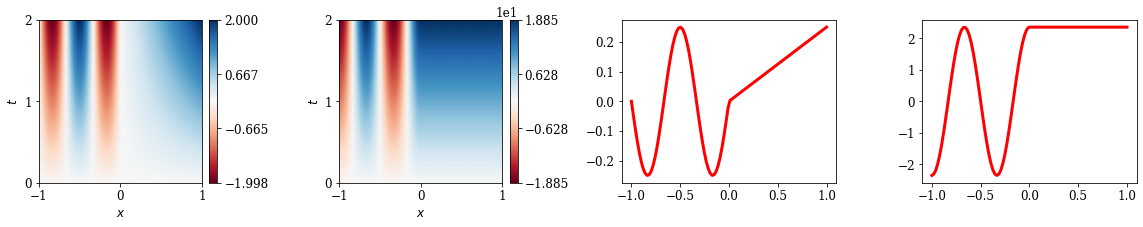

In [5]:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable,min_val,max_val):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    ticks = np.linspace(min_val, max_val, 4, endpoint=True)
    cbar = fig.colorbar(mappable, cax=cax,ticks=ticks)
    cbar.formatter.set_powerlimits((0, 0))
    plt.sca(last_axes)
    return cbar

params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels
    'axes.titlesize': 12,
    'font.size': 12, 
    'legend.fontsize': 12, 
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False,
    'figure.figsize': [20, 3],
    'font.family': 'serif',
}
plt.rcParams.update(params)

domain   = np.array([[-1.,0.],[1.,2.]])
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = cmap_list[8]
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=0.4)

xstar = np.linspace(domain[0][0],domain[1][0],100)
tstar = np.linspace(domain[0][1],domain[1][1],100)


x_star,t_star = np.meshgrid(xstar,tstar)
x_test = torch.from_numpy(x_star.flatten()[:,None])
t_test = torch.from_numpy(t_star.flatten()[:,None])


u_star  = torch.from_numpy(vectorize(u_exact)(x_test,t_test))   
s_star  = torch.from_numpy(vectorize(sigma_exact)(x_test,t_test))   



points      = np.concatenate((x_star.flatten()[:,None],t_star.flatten()[:,None]),axis=1)
u_star_plot = griddata(points, u_star.flatten(), (x_star,t_star), method='cubic')
s_star_plot = griddata(points, s_star.flatten(), (x_star,t_star), method='cubic')


plt.figure()
ax = plt.subplot(gs[0,0])
min_val = np.min(u_star_plot)
max_val = np.amax(u_star_plot)
img=ax.pcolormesh(x_star,t_star,u_star_plot, cmap = cmap,vmin=min_val,vmax=max_val,shading='gouraud')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
cbar = colorbar(img,min_val,max_val)
cbar.formatter.set_powerlimits((0, 0))
ax.axis('square')
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])



ax = plt.subplot(gs[0,1])
min_val = np.min(s_star_plot)
max_val = np.amax(s_star_plot)
img= ax.pcolormesh(x_star,t_star,s_star_plot, cmap = cmap,vmin=min_val,vmax=max_val,shading='gouraud')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
cbar = colorbar(img,min_val,max_val)
cbar.formatter.set_powerlimits((0, 0))
ax.axis('square')
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])

ax = plt.subplot(gs[0,2])
x_star   = np.linspace(domain[0][0],domain[1][0],100)
t_star   = np.ones_like(x_star) * 0.25
u_star   = vectorize(u_exact)(x_star,t_star)
ax.plot(x_star,u_star,'r',linewidth=3.0)

ax = plt.subplot(gs[0,3])
x_star   = np.linspace(domain[0][0],domain[1][0],100)
t_star   = np.ones_like(x_star) * 0.25
s_star   = vectorize(sigma_exact)(x_star,t_star)
ax.plot(x_star,s_star,'r',linewidth=3.0)
plt.show()

In [6]:
def fetch_collocation_points(domain,N_data):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """

    dim = domain.shape[0]
    soboleng = torch.quasirandom.SobolEngine(dimension=dim,scramble=True)
    data     = soboleng.draw(N_data,dtype=dtype)*(domain[1] - domain[0]) + domain[0]
    x        = data[:,0][:,None]
    t        = data[:,1][:,None]
    return x,t

In [7]:
def fetch_initial_points(domain,N_data):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    t_min    = domain[0][1]
    
    soboleng = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
    x     = soboleng.draw(N_data,dtype=dtype)*(x_max - x_min) + x_min
    data  = torch.cat((x, torch.full_like(x,t_min)), dim = 1)
    x      = data[:,0][:,None]
    t      = data[:,1][:,None]
    return x,t

In [8]:
def fetch_boundary_points(domain,N_data):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    
    t_min    = domain[0][1]
    t_max    = domain[1][1]
    
    soboleng = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
    t        = soboleng.draw(N_data,dtype=dtype)*(t_max - t_min) + t_min
    
    E_bc = torch.cat(( torch.full_like(t,x_max),t), dim = 1)
    W_bc = torch.cat(( torch.full_like(t,x_min),t), dim = 1)

    data   = torch.cat((E_bc, W_bc), dim = 0)
    
    x      = data[:,0][:,None]
    t      = data[:,1][:,None]
    return x,t

In [9]:
def pde_opt(model,x_dm,t_dm,k_dm,f_dm):
    u,s     = model(x_dm,t_dm)
    u_x,u_t = torch.autograd.grad(u.sum(),(x_dm,t_dm),create_graph=True)
    s_x     = torch.autograd.grad(s.sum(),x_dm,create_graph=True)[0]
    pde     = (u_t - s_x - f_dm).pow(2) 
    flux    = (s - k_dm * u_x).pow(2)
    return pde,flux

In [10]:
def boundary_opt(model,x_bc,t_bc,u_bc):
    u,_ = model(x_bc,t_bc) 
    loss = (u - u_bc).pow(2)
    return loss

In [11]:
def initial_opt(model,x_ic,t_ic,u_ic):
    u,_  = model(x_ic,t_ic) 
    loss = (u - u_ic)
    return loss

In [12]:
kwargs   = {"mean":torch.tensor([0., 1.00]), "stdev":torch.tensor([0.5773, 0.5773])}    # [-1,0]x[1,2]
domain   = np.array([[-1,0.],[1.,2.]])
layers   = [2,20,20,20,20,2]
model    = Network(layers,**kwargs)
model.apply(init_weights)
print(model)
print(model.mu)
print(model.stdev)

Network(
  (net): Sequential(
    (0): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (1): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (2): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (3): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)
tensor([0., 1.])
tensor([0.5773, 0.5773])


In [13]:
sum([p.numel() for p in model.parameters()])

1362

In [14]:
def evaluate(model,domain):
    model.eval()
    xstar = np.linspace(domain[0][0],domain[1][0],100)
    tstar = np.linspace(domain[0][1],domain[1][1],100)

    x_star,t_star = np.meshgrid(xstar,tstar)
    x_test = torch.from_numpy(x_star.flatten()[:,None])
    t_test = torch.from_numpy(t_star.flatten()[:,None])

    u_star     = torch.from_numpy(vectorize(u_exact)(x_test,t_test))
    s_star     = torch.from_numpy(vectorize(sigma_exact)(x_test,t_test))
    
    u_pred,s_pred = model(x_test,t_test)
    
    u_l2   = np.linalg.norm(u_star- u_pred.detach(), 2)/np.linalg.norm(u_star, 2)
    s_l2   = np.linalg.norm(s_star- s_pred.detach(), 2)/np.linalg.norm(s_star, 2)
    
    return u_l2,s_l2

In [15]:
# number of collocation points in the domain
N_data     = 2028
x_dm,t_dm  = fetch_collocation_points(domain,N_data)
k_dm       = torch.from_numpy(vectorize(k_exact)(x_dm,t_dm))
f_dm       = torch.from_numpy(vectorize(source_exact)(x_dm,t_dm))
x_dm       = x_dm.requires_grad_(True)
t_dm       = t_dm.requires_grad_(True)


# number of boundary points
N_data     = 512 # each side 
x_bc,t_bc  = fetch_boundary_points(domain,N_data)
u_bc       = torch.from_numpy(vectorize(u_exact)(x_bc,t_bc))


# number of initial condition points
N_data     = 512
x_ic,t_ic  = fetch_initial_points(domain,N_data)
u_ic       = torch.from_numpy(vectorize(u_exact)(x_ic,t_ic))

In [16]:
optimizer   = LBFGS(model.parameters(),line_search_fn='strong_wolfe')

In [17]:
lambda_flux = torch.ones_like(x_dm)
lambda_bc   = torch.ones_like(x_bc)
lambda_ic   = torch.ones_like(x_ic)


vi_flux     = torch.zeros_like(x_dm)
vi_bc       = torch.zeros_like(x_bc)
vi_ic       = torch.zeros_like(x_ic)

moment          = 0.9
lr              = 1.0

epochs          = 10000

In [18]:
# starting to train neural network model
for epoch in tqdm(range(epochs)):
    
    def closure():
        optimizer.zero_grad()
        physics_res,flux_res = pde_opt(model,x_dm,t_dm,k_dm,f_dm)
            
        flux_loss =(lambda_flux * flux_res).sum()

        boundary_res = boundary_opt(model,x_bc,t_bc,u_bc)
        boundary_loss = (lambda_bc * boundary_res).sum()
            
        initial_res   = initial_opt(model,x_ic,t_ic,u_ic)
        initial_loss  = (lambda_ic * initial_res).sum()
            
        loss      = physics_res.sum() +  flux_loss  + boundary_loss + initial_loss
        if loss.requires_grad:
            loss.backward()
        return loss
    def _closure():
        optimizer.zero_grad()
        physics_res,flux_res = pde_opt(model,x_dm,t_dm,k_dm,f_dm)
        boundary_res = boundary_opt(model,x_bc,t_bc,u_bc)
        initial_res   = initial_opt(model,x_ic,t_ic,u_ic)
        return flux_res,boundary_res,initial_res
    
    
    
    optimizer.step(closure)
    flux_res,boundary_res,initial_res = _closure()
        
    with torch.no_grad():
        vi_flux      = (1.0 - moment) * flux_res.pow(2) + moment * vi_flux
        vi_bc        = (1.0 - moment) * boundary_res.pow(2)  + moment * vi_bc
        vi_ic        = (1.0 - moment) * initial_res.pow(2)   + moment * vi_ic
    
        
        lambda_flux  += lr / ( vi_flux   + 1e-8).sqrt()   * flux_res
        lambda_bc    += lr / ( vi_bc     + 1e-8).sqrt()   * boundary_res
        lambda_ic    += lr / ( vi_ic     + 1e-8).sqrt()   * initial_res
        
        if (epoch + 1)%1000 == 0 :
            u_l2,s_l2 = evaluate(model,domain)
            print(f" u l2 error :{u_l2:2.3e}, s l2 error : {s_l2 :2.3e}")

 10%|█         | 1000/10000 [06:21<57:54,  2.59it/s] 

 u l2 error :6.497e-03, s l2 error : 2.756e-03


 20%|██        | 2000/10000 [12:44<48:08,  2.77it/s]  

 u l2 error :7.000e-03, s l2 error : 1.964e-03


 30%|███       | 3000/10000 [19:08<48:11,  2.42it/s]  

 u l2 error :4.799e-03, s l2 error : 2.008e-03


 40%|████      | 4000/10000 [25:29<43:34,  2.30it/s]  

 u l2 error :4.227e-03, s l2 error : 1.880e-03


 50%|█████     | 5000/10000 [31:40<33:47,  2.47it/s]

 u l2 error :3.482e-03, s l2 error : 1.620e-03


 60%|██████    | 6000/10000 [38:06<24:07,  2.76it/s]  

 u l2 error :4.560e-03, s l2 error : 1.512e-03


 70%|███████   | 7000/10000 [44:14<18:18,  2.73it/s]

 u l2 error :5.240e-03, s l2 error : 1.707e-03


 80%|████████  | 8000/10000 [50:30<12:34,  2.65it/s]

 u l2 error :5.336e-03, s l2 error : 1.955e-03


 90%|█████████ | 9000/10000 [56:44<06:15,  2.66it/s]

 u l2 error :4.743e-03, s l2 error : 1.659e-03


100%|██████████| 10000/10000 [1:02:52<00:00,  2.65it/s]

 u l2 error :4.223e-03, s l2 error : 1.536e-03


In [14]:
model.load_state_dict(torch.load("models/Heat_Composite_Wall.pt"))
model.eval()
xstar = np.linspace(domain[0][0],domain[1][0],64)
tstar = np.linspace(domain[0][1],domain[1][1],64)

x_star,t_star = np.meshgrid(xstar,tstar)
x_test = torch.from_numpy(x_star.flatten()[:,None])
t_test = torch.from_numpy(t_star.flatten()[:,None])


u_star  = torch.from_numpy(vectorize(u_exact)(x_test,t_test))  
s_star  = torch.from_numpy(vectorize(sigma_exact)(x_test,t_test))  

u_pred,s_pred= model(x_test,t_test)

In [15]:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable,min_val,max_val,limit):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    ticks = np.linspace(min_val, max_val, 4, endpoint=True)
    cbar = fig.colorbar(mappable, cax=cax,ticks=ticks)
    cbar.formatter.set_powerlimits((limit, limit))
    plt.sca(last_axes)
    return cbar

params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels
    'axes.titlesize': 24,
    'font.size'     : 20, 
    'legend.fontsize': 18, 
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': False,
    'figure.figsize': [3, 3],
    'font.family': 'serif',
}
plt.rcParams.update(params)
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = plt.cm.get_cmap(cmap_list[8]).reversed()

In [16]:
# ------------
# 2D figures
# --------------
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = cmap_list[8]
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.3)

points      = np.concatenate((x_star.flatten()[:,None],t_star.flatten()[:,None]),axis=1)
u_pred_plot = griddata(points, u_pred.detach().flatten(), (x_star,t_star), method='cubic')
u_star_plot = griddata(points, u_star.flatten(), (x_star,t_star), method='cubic')

s_pred_plot = griddata(points, s_pred.detach().flatten(), (x_star,t_star), method='cubic')
s_star_plot = griddata(points, s_star.flatten(), (x_star,t_star), method='cubic')

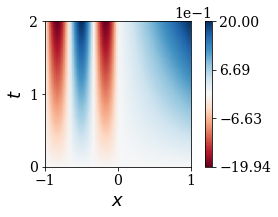

In [17]:
min_val = np.min(u_star_plot)
max_val = np.amax(u_star_plot)

#################################### Predicted Solution #####################################
ax = plt.subplot(gs[0,0])
img = ax.pcolormesh(x_star,t_star,u_pred_plot, cmap = cmap,vmin=min_val,vmax=max_val,shading='gouraud')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.axis('square')
cbar = colorbar(img,min_val,max_val,limit=-1)
# cbar.formatter.set_powerlimits((-1, -1))
ax.axis('square')
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])
plt.savefig('figures/predicted_heat_solution.png',bbox_inches='tight', pad_inches=0.01)
plt.show()

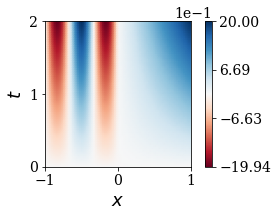

In [18]:
# #################################### Exact Solution #########################################
ax = plt.subplot(gs[0,0])
img = ax.pcolormesh(x_star,t_star,u_star_plot, cmap = cmap,vmin=min_val,vmax=max_val,shading='gouraud')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
cbar = colorbar(img,min_val,max_val,limit=-1)
ax.axis('square')
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])
plt.savefig('figures/exact_heat_solution.png',bbox_inches='tight', pad_inches=0.01)
plt.show()

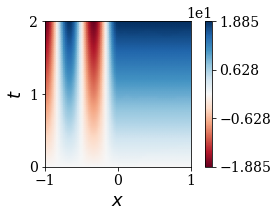

In [19]:
min_val = np.min(s_star_plot)
max_val = np.amax(s_star_plot)

#################################### Predicted flux #####################################
ax = plt.subplot(gs[0,0])
img = ax.pcolormesh(x_star,t_star,s_pred_plot, cmap = cmap,vmin=min_val,vmax=max_val,shading='gouraud')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.axis('square')
cbar = colorbar(img,min_val,max_val,limit=1)
ax.axis('square')
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])
plt.savefig('figures/predicted_heat_flux.png',bbox_inches='tight', pad_inches=0.01)
plt.show()

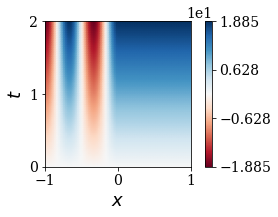

In [20]:
min_val = np.min(s_star_plot)
max_val = np.amax(s_star_plot)

#################################### exact flux #####################################
ax = plt.subplot(gs[0,0])
img = ax.pcolormesh(x_star,t_star,s_star_plot, cmap = cmap,vmin=min_val,vmax=max_val,shading='gouraud')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.axis('square')
cbar = colorbar(img,min_val,max_val,limit=0)
ax.axis('square')
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])
plt.savefig('figures/exact_heat_flux.png',bbox_inches='tight', pad_inches=0.01)
plt.show()

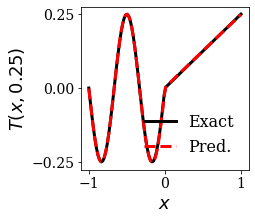

In [33]:
ax = plt.subplot(gs[0,0])
x_star   = np.linspace(domain[0][0],domain[1][0],100)[:,None]
t_star   = np.full_like(x_star,0.25)

u_star   = vectorize(u_exact)(x_star,t_star)
u_pred,_ = model(torch.from_numpy(x_star),torch.from_numpy(t_star))

ax.plot(x_star,u_star,'k',linewidth=3.0,label=r'Exact')
ax.plot(x_star,u_pred.detach(),'--r',linewidth=3.0,label=r'Pred.')
ax.set_xlabel('$x$')
ax.set_ylabel('$T(x,0.25)$')
ax.legend(frameon=False)
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([-0.25,0,0.25])
ax.legend(frameon=False,fontsize=16)
plt.savefig('figures/verification_heat_line_plot.png',bbox_inches='tight', pad_inches=0.01)
plt.show()

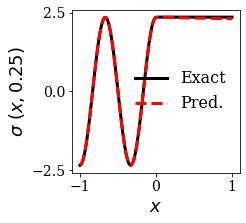

In [32]:
ax = plt.subplot(gs[0,0])
x_star   = np.linspace(domain[0][0],domain[1][0],100)[:,None]
t_star   = np.full_like(x_star,0.25)
s_star   = vectorize(sigma_exact)(x_star,t_star)
_,s_pred = model(torch.from_numpy(x_star),torch.from_numpy(t_star))

ax.plot(x_star,s_star,'k',linewidth=3.0,label='Exact')
ax.plot(x_star,s_pred.detach(),'--r',linewidth=3.0,label=r'Pred.')

ax.set_xlabel('$x$')
ax.set_ylabel('$\sigma ~ (x,0.25)$')
ax.legend(frameon=False,fontsize=16)
ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
ax.set_yticks([-2.5,0,2.5])
plt.savefig('figures/verification_heat_flux_line_plot.png',bbox_inches='tight', pad_inches=0.01)
plt.show()